# Defining required imports

In [1]:
import nltk
import re
from nltk.corpus import brown
from nltk.chunk import regexp
from nltk.collocations import *
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from urllib.request import urlopen
import random
import operator
import json
import string
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.svm import SVC

from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords
pstemmer = nltk.PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

# Code for classifer or sentiment analyzer

In [2]:
# Fetching the labelled data and training the classifier
train_data_file_name = 'train_data.csv'

train_data_df = pd.read_csv(train_data_file_name, encoding = "ISO-8859-13")
train_data_df.columns = ["Text","Sentiment"]

In [3]:
# Value counts for the labelled data
train_data_df.Sentiment.value_counts()

 1    2248
 0    2061
-1    1628
dtype: int64

In [4]:
# Calculating the np.mean for the Text in the training data
np.mean([len(s.split(" ")) for s in train_data_df.Text])

6.306889001179047

In [5]:
# Stemming, tokenizing and vectorizing the features
stemmer = pstemmer
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems

# vectorizer = CountVectorizer(
#     analyzer = 'word', # Assigning analyzer as word
#     tokenizer = tokenize,
#     lowercase = True, # Lowercasing the words
#     stop_words = 'english', # For removing stop words from being considered as features
#     ngram_range = (1,3), # Allowing unigrams, bigrams, and trigrams to be considered as features
#     max_features = 50 # Using the top 1000 features
# )

vectorizer = TfidfVectorizer(
    analyzer = 'word',
    min_df=1,
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    ngram_range = (1,3),
    max_features = 1000
)

In [6]:
# Extracting the features from training data
corpus_data_features = vectorizer.fit_transform(train_data_df.Text.tolist())

In [7]:
# Feature to array
corpus_data_features_nd = corpus_data_features.toarray()
corpus_data_features_nd.shape

# Removing features with less than 3 characters
vocab = vectorizer.get_feature_names()
vocab = [word.lower() for word in vocab if len(word) > 2]

In [8]:
# remember that corpus_data_features_nd contains all of our 
# original train and test data, so we need to exclude
# the unlabeled test entries

X_train, X_dev, y_train, y_dev  = train_test_split(
        corpus_data_features_nd, 
        train_data_df.Sentiment,
        train_size=0.99, 
        random_state=1234)

In [9]:
# Training the classifiers on the training set

log_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=1000)
svm_model = SVC(kernel='linear', C = 1.0)

log_model = log_model.fit(X=X_train, y=y_train)
rf_model = rf_model.fit(X=X_train, y=y_train)
svm_model = svm_model.fit(X=X_train, y=y_train)

In [10]:
# Performing predictions on the dev set
y_log_pred = log_model.predict(X_dev)
y_rf_pred = rf_model.predict(X_dev)
y_svm_pred = svm_model.predict(X_dev)

In [11]:
# Classifier report for the Logistic Regression model
from sklearn.metrics import classification_report
print(classification_report(y_dev, y_log_pred))

             precision    recall  f1-score   support

         -1       0.71      0.71      0.71        17
          0       0.68      0.85      0.76        20
          1       0.89      0.70      0.78        23

avg / total       0.77      0.75      0.75        60



In [12]:
# Classifier report for the Random Forest Model
print(classification_report(y_dev, y_rf_pred))

             precision    recall  f1-score   support

         -1       0.78      0.82      0.80        17
          0       0.65      0.75      0.70        20
          1       0.89      0.74      0.81        23

avg / total       0.78      0.77      0.77        60



In [13]:
# Classifier report for the SVM Model
print(classification_report(y_dev, y_svm_pred))

             precision    recall  f1-score   support

         -1       0.67      0.59      0.62        17
          0       0.58      0.75      0.65        20
          1       0.84      0.70      0.76        23

avg / total       0.70      0.68      0.69        60



### Model 1 : Logistic Regression Model

In [14]:
# Training the classifier on the whole training data available
log_model = LogisticRegression()
log_model = log_model.fit(X=corpus_data_features_nd, y=train_data_df.Sentiment)

In [15]:
# Creating method to get predictions for the test data

def get_Predictions_LR(df_dict, vectorizer):
    predictions_dict = {}
    for feature in df_dict:
        test_data_df = df_dict[feature]
        corpus_data_features_test_vector = vectorizer.transform(test_data_df.Text.tolist())
        corpus_data_features_test = corpus_data_features_test_vector.toarray()
        print (feature)
        test_log_pred = log_model.predict(corpus_data_features_test)
        predictions_dict[feature] = test_log_pred
        
    return predictions_dict

### Model 2 : Random Forest Model

In [16]:
# Training the classifier on the whole training data available
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model = rf_model.fit(X=corpus_data_features_nd, y=train_data_df.Sentiment)

In [17]:
# Creating method to get predictions for the test data

def get_Predictions_RF(df_dict, vectorizer):
    predictions_dict = {}
    for feature in df_dict:
        test_data_df = df_dict[feature]
        corpus_data_features_test_vector = vectorizer.transform(test_data_df.Text.tolist())
        corpus_data_features_test = corpus_data_features_test_vector.toarray()
        
        test_log_pred = rf_model.predict(corpus_data_features_test)
        predictions_dict[feature] = test_log_pred
        
    return predictions_dict

# Writing Methods for Processing Review Data

## Step 1 - Defining methods for splitting complex review statements

### i.e. Splitting sentences containing multiple features, into single feature phrases.

In [18]:
# Defining the tokenizer for the sentences
def normAndTokenizeSentences(dictionaryOfData):

    normalizedData = {}
    keys = dictionaryOfData.keys()
    
    for key in keys:
        review = dictionaryOfData[key]
        review_as_list_of_sentences = []
        for sentence in re.split(r'[.,:;!]', review):
            if sentence:
                sentence = ' '.join([word.lower().strip() for word in sentence.split()])
                review_as_list_of_sentences.append(sentence)
        
        normalizedData[key] = review_as_list_of_sentences
    
    return normalizedData

In [19]:
# Building backoff tagger for the review data, with specific added training set for 'not'

def build_backoff_tagger_trigram (train_sents):
    t0 = nltk.DefaultTagger("NN")
    t1 = nltk.UnigramTagger(train_sents, backoff = t0)
    t2 = nltk.BigramTagger(train_sents, backoff=t1)
    t3 = nltk.TrigramTagger(train_sents, backoff=t2)
    return t3

sample_sents = brown.tagged_sents(categories=['news', 'editorial', 'reviews'])

addTrainingset = [[('The', 'AT'),  ('battery', 'NN'),  ('is', 'BEZ'),  ('not', 'RB'), ('working', 'VBG'),  ('well', 'RB'), ('.','.')],
                  [('Fast', 'NN'),  ('shipping', 'VBG'),  ('and', 'CC'),  ('everything', 'PN'),  ('however', 'CC'),  ('after', 'IN'),  ('about', 'RB'),  ('two', 'CD'),  ('months', 'NNS'),  ('of', 'IN'),  ('using', 'VBG'),  ('the', 'AT'),  ('phones', 'NNS'), ('white', 'JJ'),  ('lines', 'NNS'),  ('appeared', 'VBD'),  ('on', 'IN'), ('it', 'IN'), ('.','.')],
                  [('The', 'AT'),  ('battery', 'NN'),  ('is', 'BEZ'),  ('not', 'RB'), ('working', 'VBG'),  ('well', 'RB'), ('.','.')],
                  [('After', 'IN'),  ('less', 'AP'),  ('than', 'IN'),  ('six', 'CD'),  ('months', 'NNS'),  ('the', 'AT'),  ('screen', 'NN'), ('is', 'BEZ'),  ('not', 'RB'),  ('working', 'VBG')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('not', 'RB')]
]

#Training the tagger
ngram_tagger = build_backoff_tagger_trigram(sample_sents + addTrainingset + addTrainingset + addTrainingset + addTrainingset)

In [20]:
# Define tag sentences for tagging sentences based on ngram_tagger
def tag_sentences(cleaned_dictionaryData):
    tagged_dictionaryData = {}
    keys = cleaned_dictionaryData.keys()
    
    for key in keys:
        data = cleaned_dictionaryData[key]
        temp = []
        for sentence in data:
            x = ngram_tagger.tag(nltk.word_tokenize(sentence))
            temp.append(x)

        tagged_dictionaryData[key] = temp
    return tagged_dictionaryData

In [21]:
# Defining the method which performs the splitting on each sentence of each review
def split_taggedSentences(tagged_sentences):
    keys = tagged_sentences.keys()
    
    splitData = {}

    for key in keys:
        reviewData = tagged_sentences[key]
        reviewDataList = []

        for sentence in reviewData:
            temp = []
            for word, tag in sentence:
                if tag != 'CC':
                    temp.append(word)

                else :
                    if temp:
                        sent = ' '.join(temp)
                        reviewDataList.append(sent)
                        temp = []

            #Adding the final temp
            sent = ' '.join(temp)
            reviewDataList.append(sent)
        splitData[key] = reviewDataList
        
    return splitData

In [22]:
# Creating the method which needs to be called to split the reviews into single feature phrases

def split_reviewData(filename):
    with open(filename) as f:
        data = f.read().split('\n')
        
    dictionaryOfData = {}
    for each_review in data:
        temp = each_review.split('|')
        if len(temp) > 1:
            dictionaryOfData[temp[0]] = str(temp[1])
        
    cleaned_Sent_Tokens = normAndTokenizeSentences(dictionaryOfData)
    tagged_sentences = tag_sentences(cleaned_Sent_Tokens)
    
    force_tags = {'not': 'RB', 'however' : 'CC', 'but' : 'CC'}

    keys = tagged_sentences.keys()
    for key in keys:
        review = tagged_sentences[key]
        temp_review = []
        for sentence in review:
            if sentence:
                sentence = [(word, force_tags.get(word, tag)) for word, tag in sentence]
                temp_review.append(sentence)
        tagged_sentences[key] = temp_review
    
    dictionaryOfData_SplittedSentences = split_taggedSentences(tagged_sentences)
    
    return dictionaryOfData_SplittedSentences

## Step 2 - Extracting relevant features from the reviews

In [23]:
# Find maximum similarity between phrases

def max_similarity(feature1,feature2):
    from itertools import product
    sim = 0
    list1 = feature1.split(' ')
    list2 = feature2.split(' ')

    for word1, word2 in product(list1, list2):
        syns1 = wn.synsets(word1,'n')
        syns2 = wn.synsets(word2,'n')
        for sense1, sense2 in product(syns1, syns2):
            d = wn.wup_similarity(sense1, sense2)
            if d == None:
                d = 0
            if d>sim:
                sim = d
    return sim

In [24]:
# Find average similarity between phrases

def avg_similarity(feature_list1,feature_list2):
    sum_similarity = 0
    
    for feature1 in feature_list1:
        for feature2 in feature_list2:
            temp = max_similarity(feature1,feature2)
            if temp > sum_similarity:
                sum_similarity = temp
    
    return sum_similarity

In [25]:
# Find maximum similarity between terms

def max_similarity_words(term,producttype):
    from itertools import product
    sim = 0

    syns1 = wn.synsets(term,'n')
    syns2 = wn.synsets(producttype,'n')
    for sense1, sense2 in product(syns1, syns2):
        d = wn.wup_similarity(sense1, sense2)
        if d == None:
            d = 0
        if d>sim:
            sim = d
    return sim

In [26]:
# Find average similarity between terms

def avg_similarity_words(term,producttype_list):
    sum_similarity = 0
    counter = 0
    for producttype in producttype_list:
        sum_similarity += max_similarity_words(term,producttype)
        counter += 1
    avg = sum_similarity/counter 
    return avg

In [27]:
# Returning most frequent chunks

def freq_chunks (all_chunks_sep, num_terms=30):
    top_chunks = nltk.FreqDist(all_chunks_sep).most_common(num_terms) #get the num_terms most frequent
    return [item for (item,count) in top_chunks]

In [28]:
# Get the chunks from the chunked and tagged sentences

def get_just_chunks(chunked_sents,chunk_type='P1'):
    all_chunks = []

    for sent in chunked_sents:
        chunks = []
        # iterate through subtrees / leaves to get individual chunks
        raw_chunks = [subtree.leaves() for subtree in sent.subtrees()
                      if subtree.label() == chunk_type]
        for raw_chunk in raw_chunks:
            chunk = []
            for word_tag in raw_chunk:
                chunk.append(word_tag[0])
            chunks.append(' '.join(chunk))
        if chunks != []:
            all_chunks.append(chunks)
    
    #de-nesting all chunks
    all_chunks_sep = [chunk for chunks in all_chunks for chunk in chunks ]
    return all_chunks_sep

In [29]:
# Method for performing chunking on tagged sentences

# Defining the number of types of chunks
# i.e. Number of distinct patterns that will be chunked
# This is equal to the number of patterns provided the grammar for the chunking method
chunktypes = 3

def chunk_tagged_sents(tagged_sents):
    grammar = r"""
    P1:{<JJ.*|NN.*><NN.*>+}  # battery charging system
    P2:{<RB|RBR|RBS><JJ.*|NN.*>+}  # Shows noun doing action
    P3:{<NN.*>+}  # battery life, lcd screen
    """

    chunker = regexp.RegexpParser(grammar, loop=2)
    chunked_sents = [chunker.parse(tagged_sent) for tagged_sent in tagged_sents]
    
    return chunked_sents

In [30]:
# Tokenize and tag the text corpus
# Returns list of pos-tagged sentences

def tokenize_and_tag_text(corpus):
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sents = sent_tokenizer.tokenize(corpus) # Split text into sentences 
    sents = [nltk.word_tokenize(word) for word in raw_sents] # tokenize sentences
    tagged_POS_sents = [nltk.pos_tag(word) for word in sents] # tags sentences
    return tagged_POS_sents

In [31]:
# Code for effectively display data in tabular format

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [32]:
# Creating the method which needs to be called to extract a dictionary of relevant features
# The keys are the relevant features
# The values are the list of unigrams which are similar to the feature words.

def extract_Relevant_Features(filename):
    with open(filename, 'r') as text_file:
        my_corpus = text_file.read().split('\n')
        
    # Initializing list for tokenized and tagged corpus
    token_and_tagged_corpus = []
    
    # For each record, calling the tokenizer and tagger
    for record in my_corpus:
        if record:
            text = record.split('|')[1]
            token_and_tagged_corpus += tokenize_and_tag_text(text)
            
    # Chunking the tagged, and tokenized corpus
    chunk_sents = chunk_tagged_sents(token_and_tagged_corpus)
    
    # From the chunked data, retrieve the list
    chunks_list = []
    chunk_header = []

    for i in range(chunktypes):
        chunktype = 'P'+str(i+1)
        chunks_from_sents = get_just_chunks(chunk_sents,chunktype)
        freq_type_chunks = freq_chunks (chunks_from_sents,100)
        chunk_header.append(chunktype)
        chunks_list.append(freq_type_chunks)
        
    table_chunking = ListTable()
    table_chunking.append(chunk_header)

    iteration = 0
    for chunklist in chunks_list:
        if len(chunklist) > iteration:
            iteration = len(chunklist)
    
    for i in range(iteration):
        row = []
        for chunklist in chunks_list:
            if i < len(chunklist):
                row.append(chunklist[i])
            else:
                row.append('')

        table_chunking.append(row)
    
    wnl = WordNetLemmatizer()
    word_dict = {}
    features = []
    for row in table_chunking:
        for col in row:
            features.append(col)
            
    for feature in features:
        words = feature.split(' ')
        for word in words:
            word_lemma = wnl.lemmatize(word.lower())
            if word_lemma in word_dict: word_dict[word_lemma].append(feature)
            else: word_dict[word_lemma] = [feature]

    key_pair_dict = {}

    for key1 in word_dict:
        if wn.synsets(key1,'n') == []: 
            continue    
        for key2 in word_dict:
            if key1 == key2: 
                continue
            if wn.synsets(key2,'n') == []: 
                continue
            key_pair = tuple(sorted([key1,key2]))
            if key_pair in key_pair_dict: 
                continue
            else: 
                feature_list1 = word_dict[key1]
                feature_list2 = word_dict[key2]
                similarity = avg_similarity(feature_list1,feature_list2)
                if similarity > 0.8:
                    key_pair_dict[key_pair] = similarity

    sorted_key_pair_dict = sorted(key_pair_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    key_pair_list = []
    for keypair, sim in sorted_key_pair_dict:
        key_pair_list.append(keypair)
        
    topics = {}
    keypair_copy = key_pair_list[:]

    for key11,key12 in key_pair_list:
        for keypair2 in key_pair_list:
            if key11 == keypair2[0] and key12 == keypair2[1]: continue
            if key11 in keypair2:
                if key11 in topics: topics[key11] += [keypair2[0],keypair2[1]]
                else: 
                    topics[key11]= [key11,key12,keypair2[0],keypair2[1]]
            if key12 in keypair2:
                if key12 in topics: topics[key12] += [keypair2[0],keypair2[1]]
                else: 
                    topics[key12]= [key11,key12,keypair2[0],keypair2[1]]
    
    for item in topics:
        topics[item] = list(set(topics[item]))
        
    term_list = []
    for topic in topics:
        term_list.append(topic)
    producttype = ['cell','phone','telephone','mobile']
    
    # Dictionary with final 'features' and associated list of similar words for each feature
    final_term_dict = {}

    for term in term_list:
        sim = avg_similarity_words(term, producttype)
        if sim > 0.70:
            final_term_dict[term] = list(set(topics[term]))
            
    return final_term_dict

## Step 3 - Creating a dictionary with features and list of associated single feature phrases

### Keys : Features
### Values : List of associated single feature phrases

In [33]:
# Creating the method which needs to be called to extract a dictionary of relevant features

def club_Associated_Reviews(dict_splitted_Sentences, term_dict):

    # From the splitted review data, from the split_review_sentence code
    # Club all the reviews which are related to a certain feature, as a list of sentences
    # In a dictionary, with the key as the feature, and value as the list of related sentences

    reviews_perFeature = {}
    for review_id in dict_splitted_Sentences:
        review_phrases = dict_splitted_Sentences[review_id]
        for phrase in review_phrases:
            phrase_words = phrase.split(' ')
            set1 = set(phrase_words)
            for term in term_dict:
                set2 = set([term])
                result = set1.intersection(set2)
                if result:
                    if term in reviews_perFeature: 
                        reviews_perFeature[term].append(phrase)
                    else:
                        reviews_perFeature[term] = [phrase]
                        
    df_dict = {}
    for aspect in reviews_perFeature:
        tempdict= {}
        tempdict['Text'] = reviews_perFeature[aspect]
        temp_df = pd.DataFrame(tempdict)
        df_dict[aspect] = temp_df
    
    return df_dict

# Plotting and presenting the results

In [34]:
def plot_Results(predictions_dict):
    # Variables for Product Attributes
    attr_list = []
    
    #Variables for device
    overall_list = []
    
    # Defining dictionaries for storing counts for overall device sentiment
    overall_dict = {'No Of Positive mentions' : 0, 'No Of Negative mentions' : 0}
            
    # Assigning index name to dictionaries for overall counts
    overall_dict['Aspect'] = 'device'
    
    for aspect in predictions_dict:
        if aspect not in ['phone', 'device', 'cell', 'smartphone', 'telephone', 'mobile']:

            # Defining dictionaries for storing counts
            attr_dict = {'No Of Positive mentions' : 0, 'No Of Neutral mentions' : 0, 
                                 'No Of Negative mentions' : 0}
            
            # Assigning index name
            attr_dict['Aspect'] = aspect
            
            # Calculating counts of different sentiments
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            # Storing the counts in the dictionaries
            if 1 in count:
                attr_dict['No Of Positive mentions'] = count[1]
                
            if 0 in count:
                attr_dict['No Of Neutral mentions'] = count[0] 
                
            if -1 in count:
                attr_dict['No Of Negative mentions'] = count[-1]
            
            # Appending dictionaries to lists for easier dataframe manipulation
            attr_list.append(attr_dict)
            
        else :
            # Calculating counts of different sentiments for the product
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            if 1 in count:
                overall_dict['No Of Positive mentions'] += count[1]
               
            # Commenting out code for the 'maybe' sentiment
#             if 0 in count:
#                 overall_dict['No Of Neutral mentions'] += count[0]
            
            if -1 in count:
                overall_dict['No Of Negative mentions'] += count[-1]
    
    # Appending dictionaries to lists for easier dataframe manipulation
    overall_list.append(overall_dict)

    # For overall product
    df_overall = pd.DataFrame(overall_list)
    df_overall_final= df_overall.set_index('Aspect')
    
    #For printing the re-call table for attributes
    df_attr = pd.DataFrame(attr_list)
    df_attr_final = df_attr.set_index("Aspect")
    
    print("----------------------")
    print("Apsects and number of related phrases")
    print("----------------------")
    
    display(df_attr_final)
    
    print("\n----------------------")
    print("Graph of sentiments for different attributes")
    print("----------------------")
    df_attr_final.plot(kind='bar', color=['r','b','g'],figsize=(12, 10))
    df_attr_final.to_csv('attr_df.csv')
    
    return df_overall_final # Return the overall sentiment dataframe
    
def plot_overall(df_overall):
    print("\n----------------------")
    print("Graph for overall sentiment for the product")
    print("----------------------")
    df_overall.plot(kind='bar', color=['r','b','g'],figsize=(9, 8))
    df_overall.to_csv('overall_df.csv')

# Calling Methods to Process Review Data - DEV DATA

## Step 1 - Splitting complex review statements

In [35]:
# Splitting review statements for test review data
dictionaryOfData_SplittedSentences_DEV = split_reviewData('dev_review_data.txt')

## Step 2 - Extracting relevant features

In [36]:
# Extracting relevant features for the test review data
final_term_dict_DEV = extract_Relevant_Features('dev_review_data.txt')

In [37]:
# Printing the final features
for key in final_term_dict_DEV:
    print ("Aspect : "+ key)
    print ("Related terms for the "+key+" : ")
    print (final_term_dict_DEV[key])
    print ("\n-----------\n")

Aspect : box
Related terms for the box : 
['model', 'glass', 'button', 'case', 'phone', 'lock', 'product', 'great', 'apple', 'cell', 'original', 'good', 'box']

-----------

Aspect : button
Related terms for the button : 
['android', 'button', 'last', 'thing', 'lock', 'lighter', 'apple', 'original', 'low', 'store', 'good', 'inch', 'work', 'proprietary', 'home', 'way', 'high', 'so', 'phone', 'product', 'time', 'price', 'fan', 'first', 'device', 'light', 'cell', 'buy', 'condition', 'deal', 'much', 'back', 'battery', 'cable', 'display', 'life', 'charger', 'box']

-----------

Aspect : home
Related terms for the home : 
['button', 'last', 'thing', 'lock', 'lighter', 'apple', 'store', 'good', 'inch', 'work', 'proprietary', 'home', 'way', 'so', 'light', 'product', 'price', 'fan', 'device', 'phone', 'cell', 'buy', 'condition', 'deal', 'much', 'back', 'battery', 'cable', 'display', 'life', 'charger']

-----------

Aspect : device
Related terms for the device : 
['android', 'button', 'last', 'l

## Step 3 - Associating features with related single feature phrases

In [38]:
# Getting a dictionary containing features as keys, and 
# single column dataframes containing related single feature phrases
df_dict_DEV = club_Associated_Reviews(dictionaryOfData_SplittedSentences_DEV, final_term_dict_DEV)

## Step 4 - Perform Sentiment Analysis using the trained classifer

In [39]:
# We are using Random Forest Classifier, with TF-IDF Vectorizer, as this combination provided the best results

# The output is a dictionary, with features as keys, and 
# values as a list of sentiments corresponding to each related single feature phrases
predictions_dict_RF_DEV = get_Predictions_RF(df_dict_DEV, vectorizer)

## Step 5 - Presenting the results

----------------------
Apsects and number of related phrases
----------------------


,No Of Negative mentions,No Of Neutral mentions,No Of Positive mentions
Aspect,,,
box,21,26,19
button,21,2,7
home,6,11,5
back,33,39,14
lighter,0,7,2
camera,20,12,28
battery,178,11,25
cable,6,7,2
display,4,8,6



----------------------
Graph of sentiments for different attributes
----------------------


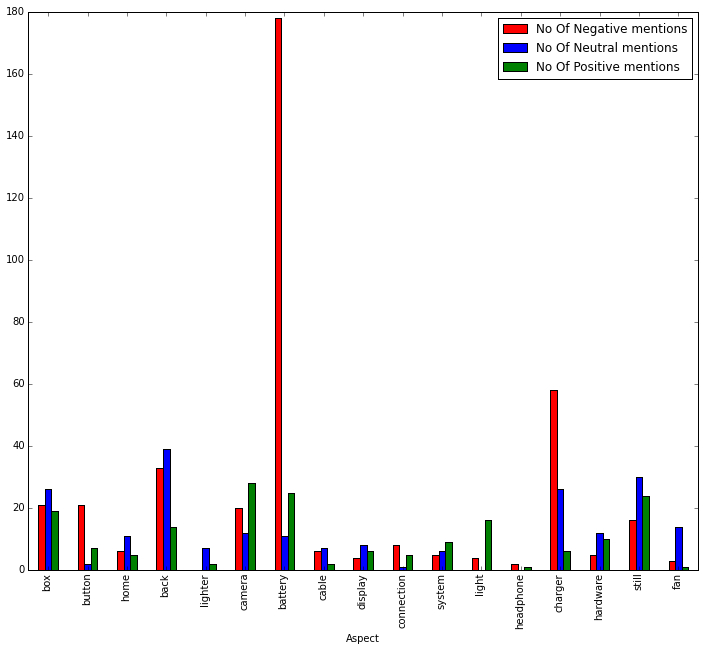

In [40]:
df_overall_DEV = plot_Results(predictions_dict_RF_DEV)


----------------------
Graph for overall sentiment for the product
----------------------


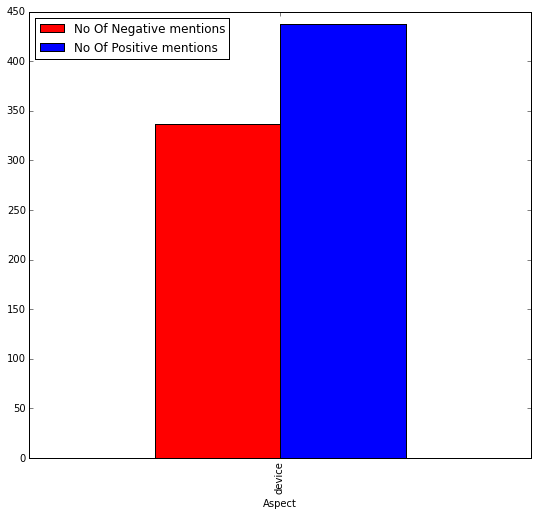

In [41]:
# Plotting the overall product sentiment
plot_overall(df_overall_DEV)

# Calling Methods to Process Review Data - TEST DATA

## Step 1 - Splitting complex review statements

In [42]:
# Splitting review statements for test review data
dictionaryOfData_SplittedSentences = split_reviewData('test_review_data.txt')

## Step 2 - Extracting relevant features

In [43]:
# Extracting relevant features for the test review data
final_term_dict = extract_Relevant_Features('test_review_data.txt')

In [44]:
# Printing the final features
for key in final_term_dict:
    print ("Aspect : "+ key,)
    print ("Related terms for the "+key+" : ")
    print (final_term_dict[key])
    print ("\n-----------\n")

Aspect : button
Related terms for the button : 
['card', 'button', 'last', 'thing', 'fingerprint', 'point', 'battery', 'so', 'good', 'work', 'home', 'sensor', 'store', 'phone', 'duplex', 'cover', 'device', 'area', 'resistance', 'cell', 'water', 'full', 'sprint', 'memory', 'notification', 'back', 'way', 'storage', 'setting', 'bar', 'display', 'life', 'scanner', 'charger', 'search']

-----------

Aspect : home
Related terms for the home : 
['card', 'button', 'last', 'thing', 'fingerprint', 'point', 'battery', 'so', 'good', 'work', 'home', 'sensor', 'store', 'phone', 'duplex', 'cover', 'device', 'area', 'resistance', 'cell', 'water', 'full', 'sprint', 'memory', 'notification', 'back', 'way', 'storage', 'setting', 'search', 'display', 'life', 'scanner', 'charger', 'bar']

-----------

Aspect : device
Related terms for the device : 
['card', 'smart', 'button', 'last', 'small', 'fingerprint', 'battery', 'video', 'system', 'android', 'hand', 'good', 'resolution', 'work', 'home', 'sensor', 'hi

## Step 3 - Associating features with related single feature phrases

In [45]:
# Getting a dictionary containing features as keys, and 
# single column dataframes containing related single feature phrases
df_dict = club_Associated_Reviews(dictionaryOfData_SplittedSentences, final_term_dict)

## Step 4 - Perform Sentiment Analysis using the trained classifer

In [46]:
# We are using Random Forest Classifier, with TF-IDF Vectorizer, as this combination provided the best results

# The output is a dictionary, with features as keys, and 
# values as a list of sentiments corresponding to each related single feature phrases
predictions_dict_RF = get_Predictions_RF(df_dict, vectorizer)

## Step 5 - Presenting the results

----------------------
Apsects and number of related phrases
----------------------


,No Of Negative mentions,No Of Neutral mentions,No Of Positive mentions
Aspect,,,
button,55,31,17
home,51,40,13
resistance,5,19,8
sensor,9,28,11
camera,102,142,275
battery,475,1,136
bar,0,15,4
display,10,46,60
system,7,23,33



----------------------
Graph of sentiments for different attributes
----------------------


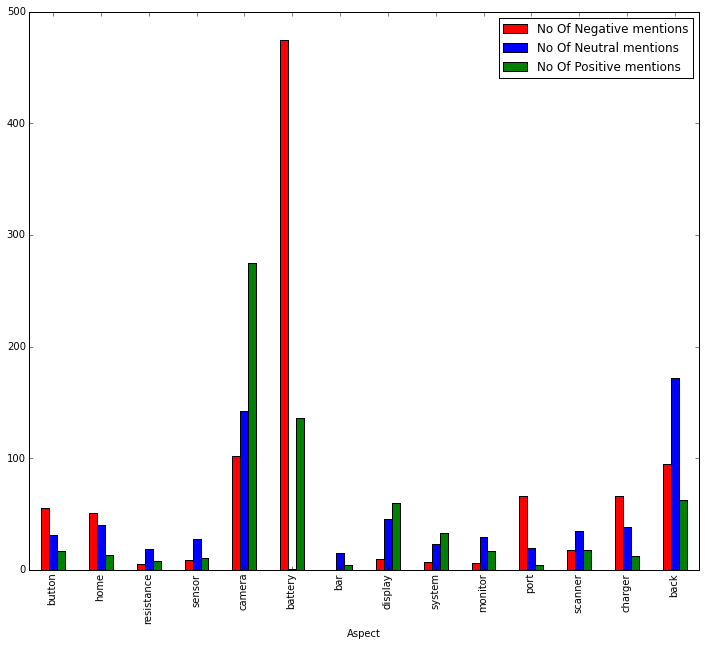

In [47]:
df_overall = plot_Results(predictions_dict_RF)


----------------------
Graph for overall sentiment for the product
----------------------


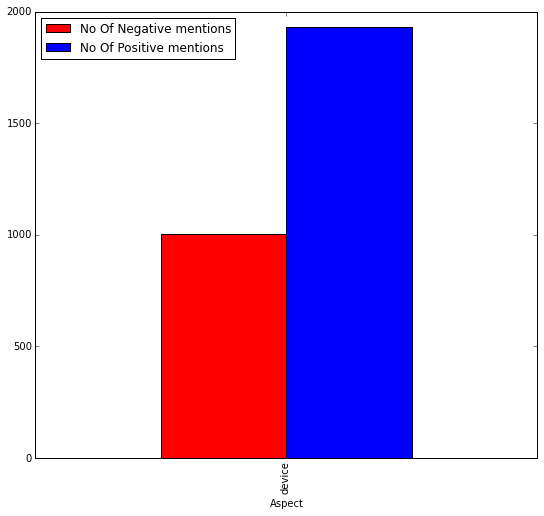

In [48]:
# Plotting the overall product sentiment
plot_overall(df_overall)

# Calling Methods to Process Review Data - TEST DATA 2 - Small DataSet

## Step 1 - Splitting complex review statements

In [49]:
# Splitting review statements for test review data
dictionaryOfData_SplittedSentences_small = split_reviewData('test_review_data_small_set.txt')

## Step 2 - Extracting relevant features

In [50]:
# Extracting relevant features for the test review data
final_term_dict_small = extract_Relevant_Features('test_review_data_small_set.txt')

In [51]:
# Printing the final features
for key in final_term_dict_small:
    print ("Aspect : "+ key,)
    print ("Related terms for the "+key+" : ")
    print (final_term_dict_small[key])
    print ("\n-----------\n")

Aspect : cell
Related terms for the cell : 
['smart', 'power', 'contract', 'lighter', 'camera', 'great', 'headphone', 'android', 'o', 'good', 'speaker', 'processor', 'so', 'light', 'google', 'nexus', 'best', 'old', 'price', 'device', 'phone', 'cell', 'call', 'drain', 'buttery', 'better', 'fast', 'battery', 'life', 'wireless', 'smooth', 'charger']

-----------

Aspect : device
Related terms for the device : 
['standard', 'smart', 'power', 'lock', 'lighter', 'camera', 'video', 'system', 'image', 'hand', 'end', 'low', 'o', 'stay', 'signal', 'work', 'experience', 'good', 'device', 'phone', 'galaxy', 'store', 'gorilla', 'grab', 'stock', 'google', 'light', 'wireless', 'nexus', 'so', 'price', 'dial', 'first', 'slot', 'part', 'assembly', 'time', 'cell', 'android', 'best', 'drain', 'order', 'con', 'glass', 'quality', 'whole', 'battery', 'play', 'display', 'life', 'hardware', 'screen', 'better', 'charger']

-----------

Aspect : light
Related terms for the light : 
['lock', 'lighter', 'nice', 's

## Step 3 - Associating features with related single feature phrases

In [52]:
# Getting a dictionary containing features as keys, and 
# single column dataframes containing related single feature phrases
df_dict_small = club_Associated_Reviews(dictionaryOfData_SplittedSentences_small, final_term_dict_small)

## Step 4 - Perform Sentiment Analysis using the trained classifer

In [53]:
# We are using Random Forest Classifier, with TF-IDF Vectorizer, as this combination provided the best results

# The output is a dictionary, with features as keys, and 
# values as a list of sentiments corresponding to each related single feature phrases
predictions_dict_RF_small = get_Predictions_RF(df_dict_small, vectorizer)

## Step 5 - Presenting the results

----------------------
Apsects and number of related phrases
----------------------


,No Of Negative mentions,No Of Neutral mentions,No Of Positive mentions
Aspect,,,
lighter,0,3,0
light,1,0,14
processor,0,6,4
white,1,9,1
camera,10,21,37
battery,46,0,20
display,3,2,9
system,1,1,10
hardware,3,4,7



----------------------
Graph of sentiments for different attributes
----------------------


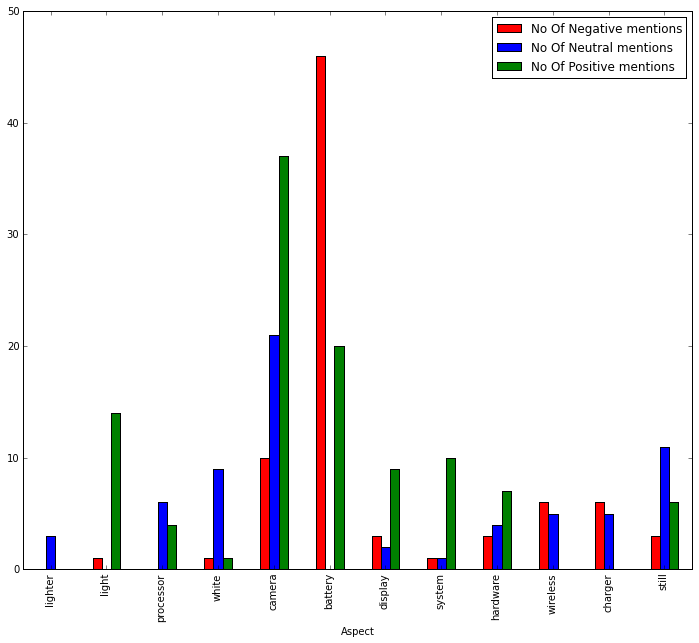

In [54]:
df_overall_small = plot_Results(predictions_dict_RF_small)


----------------------
Graph for overall sentiment for the product
----------------------


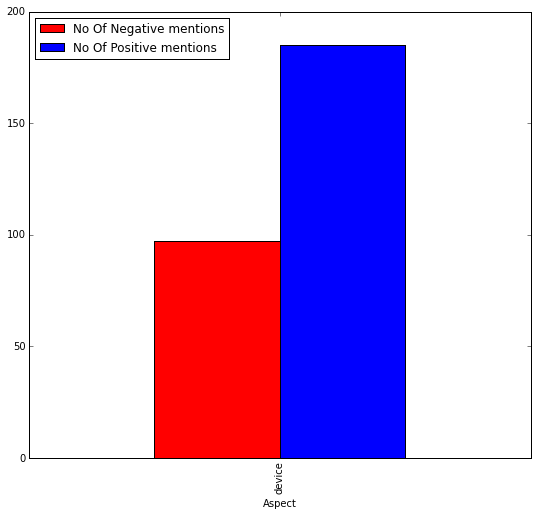

In [55]:
# Plotting the overall product sentiment
plot_overall(df_overall_small)